In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Import Packages

In [2]:
! pip install impyute

In [3]:
! pip install featuretools

     |████████████████████████████████| 296kB 6.6MB/s 
     |████████████████████████████████| 665kB 19.8MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=4c31e2938af8c02b7f4c878dcbb1c2bc3649924f8d9d7b3eea55be4957fc925d
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=abfb48250963b690ed524fb15aa1af5e979191129c6fdb031ebdbb75d73ef4e0
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2.30.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successf

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from impyute.imputation.cs import mice
import featuretools as ft
import pickle
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [5]:
def pca_fet(train, test, features, n_components, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform PCA to create new features
    pca = PCA(n_components=n_components, random_state=SEED)
    data = pca.fit_transform(data)
    columns = [f'pca_{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns = columns)
    
    # Append new features to train and test datasets
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [6]:
def svd_fet(train, test, features, n_components, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform PCA to create new features
    svd = TruncatedSVD(n_components=n_components, random_state=SEED)
    data = svd.fit_transform(data)
    columns = [f'svd_{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns = columns)
    
    # Append new features to train and test datasets
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [7]:
def kmeans_fet(train, test, features, n_clusters, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform KMeans to create new features
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(data)
    
    # Append new features to train and test datasets
    train[f'clusters_k'] = kmeans.labels_[:train.shape[0]]
    test[f'clusters_k'] = kmeans.labels_[train.shape[0]:]
    return train, test

In [8]:
def time_bins(v):
    v = str(v)
    if v>='00:00' and v<'06:00':
        return 1
    elif v>='06:00' and v<'12:00':
        return 2
    elif v>='12:00' and v<'18:00':
        return 3
    elif v>='18:00' and v<='23:60':
        return 4
    else:
        return 0

In [9]:
def logs(df, fet):
    m = df.shape[1]
    for l in fet:
        df = df.assign(newcol=pd.Series(np.log1p(df[l])).values)   
        df.columns.values[m] = l + '_log'
        m += 1
    return df

In [10]:
def sqrt(df, fet):
    m = df.shape[1]
    for l in fet:
        df = df.assign(newcol=pd.Series(np.sqrt(df[l])).values)   
        df.columns.values[m] = l + '_sqrt'
        m += 1
    return df

In [11]:
def cbrt(df, fet):
    m = df.shape[1]
    for l in fet:
        df = df.assign(newcol=pd.Series(np.cbrt(df[l])).values)   
        df.columns.values[m] = l + '_cbrt'
        m += 1
    return df

In [12]:
def squares(df, fet):
    m = df.shape[1]
    for l in fet:
        df = df.assign(newcol=pd.Series(np.power(df[l],2)).values)   
        df.columns.values[m] = l + '_squares'
        m += 1
    return df

In [13]:
def cubes(df, fet):
    m = df.shape[1]
    for l in fet:
        df = df.assign(newcol=pd.Series(np.power(df[l],3)).values)   
        df.columns.values[m] = l + '_cubes'
        m += 1
    return df

## Data Preprocessing

### Read train and predict datasets

In [58]:
train_dataset = "/content/drive/My Drive/Colab Notebooks/Carnival Wars/Dataset/train.csv"
predict_dataset = "/content/drive/My Drive/Colab Notebooks/Carnival Wars/Dataset/test.csv"

train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (6368, 15)
predict_df: (3430, 14)


### Extract "Selling_Price" field from train_df into NumPy array

In [59]:
train_df = train_df[~ train_df['Selling_Price'].isnull()]
train_df = train_df[(train_df['Selling_Price']>=0)]
print("Training dataset after removing NaN records in target label: {}".format(train_df.shape))

Training dataset after removing NaN records in target label: (6313, 15)


In [60]:
train_y = train_df['Selling_Price']
train_df.drop(['Selling_Price'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (6313,)


### Feature Engineering

In [61]:
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
combined_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0


In [62]:
# Product_id
countvec = CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=50)
features = countvec.fit_transform(combined_df.Product_id).toarray()
feature_names = ['cvp_'+col for col in countvec.get_feature_names()]
features_df = pd.DataFrame(features, columns=feature_names)
print("CountVectorizer shape: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

tfidfvec = TfidfVectorizer(ngram_range=(1,5), analyzer='char', max_features=50)
features = tfidfvec.fit_transform(combined_df.Product_id).toarray()
feature_names = ['tfvp_'+col for col in countvec.get_feature_names()]
features_df = pd.DataFrame(features, columns=feature_names)
print("TfidfVectorizer shape: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

CountVectorizer shape: (9743, 50)
TfidfVectorizer shape: (9743, 50)


In [63]:
# Stall_no
combined_df["Stall_no"].fillna(0, inplace = True)
combined_df['Stall_no'] = combined_df['Stall_no'].astype(int)
combined_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,...,tfvp_b,tfvp_br,tfvp_bra,tfvp_brae,tfvp_c,tfvp_ce,tfvp_d,tfvp_e,tfvp_ea,tfvp_ec,tfvp_eg,tfvp_f,tfvp_g,tfvp_ge,tfvp_h,tfvp_j,tfvp_k,tfvp_kc,tfvp_kce,tfvp_m,tfvp_n,tfvp_nk,tfvp_nkc,tfvp_nkce,tfvp_p,tfvp_q,tfvp_r,tfvp_ra,tfvp_rae,tfvp_rt,tfvp_s,tfvp_sh,tfvp_t,tfvp_te,tfvp_u,tfvp_v,tfvp_w,tfvp_x,tfvp_y,tfvp_z
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,1,0,0,1,1,0,0,0,2,1,1,1,1,1,0,0,0,2,0,0,0,1,2,0,0,1,...,0.156434,0.276959,0.287226,0.288286,0.000000,0.0,0.000000,0.186269,0.000000,0.0,0.0,0.155258,0.263656,0.0,0.000000,0.186726,0.000000,0.0,0.0,0.000000,0.149659,0.0,0.0,0.0,0.000000,0.000000,0.153638,0.280141,0.288020,0.0,0.000000,0.0,0.000000,0.0,0.186004,0.0,0.000000,0.1887,0.000000,0.000000
1,TUNE8SFB6RJN2HSD,38,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,...,0.210948,0.000000,0.000000,0.000000,0.000000,0.0,0.220589,0.125590,0.000000,0.0,0.0,0.209362,0.000000,0.0,0.182522,0.251796,0.000000,0.0,0.0,0.000000,0.403625,0.0,0.0,0.0,0.000000,0.000000,0.207177,0.000000,0.000000,0.0,0.429409,0.0,0.203699,0.0,0.250822,0.0,0.000000,0.0000,0.000000,0.000000
2,BRAEAR7WZPQGPBZU,9,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,0,0,0,1,0,0,2,1,2,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,...,0.285499,0.252732,0.262100,0.263068,0.000000,0.0,0.000000,0.084987,0.266805,0.0,0.0,0.000000,0.120296,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.301864,0.169935,0.280396,0.255636,0.262825,0.0,0.000000,0.0,0.000000,0.0,0.169733,0.0,0.166664,0.0000,0.000000,0.264855
3,WATDZ2ZQ8JPDHCTJ,50,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,...,0.000000,0.000000,0.000000,0.000000,0.161599,0.0,0.401278,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.166015,0.458047,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.202867,0.228410,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.370552,0.0,0.000000,0.0,0.224012,0.0000,0.000000,0.355992
4,JWSEBUKYQPMBZ3RK,7,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0.419690,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.124933,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.250480,0.432806,0.0,0.0,0.252099,0.000000,0.0,0.0,0.0,0.221873,0.249809,0.206095,0.000000,0.000000,0.0,0.213583,0.0,0.000000,0.0,0.249511,0.0,0.244999,0.0000,0.210722,0.194672


In [64]:
# instock_date
combined_df['instock_date_year'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).year)
combined_df['instock_date_quarter'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).quarter)
combined_df['instock_date_month'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).month)
combined_df['instock_date_week'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).week)
combined_df['instock_date_day_year'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).dayofyear)
combined_df['instock_date_day_month'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).day)
combined_df['instock_date_day_week'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).dayofweek)
combined_df['instock_date_day_weekend'] = np.where(combined_df['instock_date_day_week'].isin([5,6]),1,0)
combined_df['instock_date_hour'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).hour)
combined_df['instock_date_minute'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).minute)
combined_df['instock_date_second'] = combined_df['instock_date'].map(lambda x: pd.to_datetime(x).second)

In [65]:
combined_df['instock_time'] = combined_df['instock_date'].map(lambda x: datetime.datetime.time(pd.to_datetime(x)))
combined_df['instock_time'] = combined_df['instock_time'].apply(time_bins)
combined_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,...,tfvp_g,tfvp_ge,tfvp_h,tfvp_j,tfvp_k,tfvp_kc,tfvp_kce,tfvp_m,tfvp_n,tfvp_nk,tfvp_nkc,tfvp_nkce,tfvp_p,tfvp_q,tfvp_r,tfvp_ra,tfvp_rae,tfvp_rt,tfvp_s,tfvp_sh,tfvp_t,tfvp_te,tfvp_u,tfvp_v,tfvp_w,tfvp_x,tfvp_y,tfvp_z,instock_date_year,instock_date_quarter,instock_date_month,instock_date_week,instock_date_day_year,instock_date_day_month,instock_date_day_week,instock_date_day_weekend,instock_date_hour,instock_date_minute,instock_date_second,instock_time
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,1,0,0,1,1,0,0,0,2,1,1,1,1,1,0,0,0,2,0,0,0,1,2,0,0,1,...,0.263656,0.0,0.000000,0.186726,0.000000,0.0,0.0,0.000000,0.149659,0.0,0.0,0.0,0.000000,0.000000,0.153638,0.280141,0.288020,0.0,0.000000,0.0,0.000000,0.0,0.186004,0.0,0.000000,0.1887,0.000000,0.000000,2015,3,8,34,234,22,5,1,18,36,12,4
1,TUNE8SFB6RJN2HSD,38,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,...,0.000000,0.0,0.182522,0.251796,0.000000,0.0,0.0,0.000000,0.403625,0.0,0.0,0.0,0.000000,0.000000,0.207177,0.000000,0.000000,0.0,0.429409,0.0,0.203699,0.0,0.250822,0.0,0.000000,0.0000,0.000000,0.000000,2016,1,3,12,87,27,6,1,21,19,13,4
2,BRAEAR7WZPQGPBZU,9,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,0,0,0,1,0,0,2,1,2,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,...,0.120296,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.301864,0.169935,0.280396,0.255636,0.262825,0.0,0.000000,0.0,0.000000,0.0,0.169733,0.0,0.166664,0.0000,0.000000,0.264855,2015,3,8,34,230,18,1,0,19,25,22,4
3,WATDZ2ZQ8JPDHCTJ,50,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,...,0.000000,0.0,0.166015,0.458047,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.202867,0.228410,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.370552,0.0,0.000000,0.0,0.224012,0.0000,0.000000,0.355992,2016,1,3,13,88,28,0,0,21,53,1,4
4,JWSEBUKYQPMBZ3RK,7,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0.000000,0.0,0.000000,0.250480,0.432806,0.0,0.0,0.252099,0.000000,0.0,0.0,0.0,0.221873,0.249809,0.206095,0.000000,0.000000,0.0,0.213583,0.0,0.000000,0.0,0.249511,0.0,0.244999,0.0000,0.210722,0.194672,2016,1,3,13,89,29,1,0,22,58,53,4


In [66]:
# Market_Category
combined_df['Market_Bin'] = combined_df['Market_Category'].apply(lambda x: 1 if x<=100 else 2 if x>100 and x<=200 else 3)

In [67]:
# Customer_name
combined_df["Customer_name"].fillna('<>', inplace = True)
countvec = CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=50)
features = countvec.fit_transform(combined_df.Customer_name).toarray()
feature_names = ['cvc_'+col for col in countvec.get_feature_names()]
features_df = pd.DataFrame(features, columns=feature_names)
print("CountVectorizer shape: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

tfidfvec = TfidfVectorizer(ngram_range=(1,5), analyzer='char', max_features=50)
features = tfidfvec.fit_transform(combined_df.Customer_name).toarray()
feature_names = ['tfvc_'+col for col in countvec.get_feature_names()]
features_df = pd.DataFrame(features, columns=feature_names)
print("TfidfVectorizer shape: {}".format(features_df.shape))
combined_df = pd.merge(combined_df, features_df, left_index=True, right_index=True)

CountVectorizer shape: (9743, 50)
TfidfVectorizer shape: (9743, 50)


In [68]:
# Loyalty_customer and Product_Category
combined_df['Loyalty_customer'] = combined_df['Loyalty_customer'].factorize()[0]
combined_df['Product_Category'] = combined_df['Product_Category'].factorize()[0]

In [69]:
# Grade
combined_df['Grade_Bin'] = combined_df['Grade'].apply(lambda x: 1 if x<=1 else 2)

In [70]:
# charges_2 (%)
combined_df["charges_2 (%)"].fillna(0, inplace = True)
combined_df['charges_2 (%)'] = combined_df['charges_2 (%)'].astype(int)
combined_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,...,tfvc_e,tfvc_el,tfvc_en,tfvc_er,tfvc_g,tfvc_h,tfvc_ha,tfvc_i,tfvc_ia,tfvc_ie,tfvc_in,tfvc_j,tfvc_ja,tfvc_k,tfvc_ka,tfvc_l,tfvc_la,tfvc_le,tfvc_li,tfvc_ly,tfvc_m,tfvc_ma,tfvc_n,tfvc_na,tfvc_nn,tfvc_o,tfvc_on,tfvc_r,tfvc_ra,tfvc_re,tfvc_ri,tfvc_s,tfvc_t,tfvc_u,tfvc_v,tfvc_y,tfvc_ya,tfvc_yn,tfvc_z,Grade_Bin
0,BRAE2NF6JA5GUEXG,37,2015-08-22 18:36:12.000,2,Lillyann,0,0,1,68,0.0,376.0,11,2983.0,4713.0,1,0,0,1,1,0,0,0,2,1,1,1,1,1,0,0,0,2,0,0,0,1,2,0,0,1,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.159838,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.530562,0.0,0.0,0.317092,0.362189,0.0,0.0,0.315385,0.0,0.349865,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.202725,0.345469,0.000000,0.0,1
1,TUNE8SFB6RJN2HSD,38,2016-03-27 21:19:13.000,24,Klynn,0,0,0,51,0.0,397.0,12,7495.0,10352.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.338945,0.0,0.225404,0.0,0.0,0.000000,0.461618,0.0,0.0,0.401964,0.0,0.445910,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.258377,0.000000,0.440509,0.0,1
2,BRAEAR7WZPQGPBZU,9,2015-08-18 19:25:22.000,447,Ridge,0,1,0,10,0.0,250.0,9,5752.0,7309.0,0,0,0,0,0,1,0,0,2,1,2,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,...,0.258053,0.0,0.0,0.0,0.570391,0.0,0.0,0.267736,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.305515,0.00000,0.0,0.5141,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1
3,WATDZ2ZQ8JPDHCTJ,50,2016-03-28 21:53:01.000,23,Abran,0,2,2,48,0.0,144.0,13,5090.0,20814.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.253611,0.0,0.000000,0.0,0.0,0.293334,0.52864,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2
4,JWSEBUKYQPMBZ3RK,7,2016-03-29 22:58:53.000,63,Dustyn,0,3,1,35,1.0,211.0,4,2430.0,9261.0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.230001,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.332009,0.378836,0.465052,0.0,0.295683,0.000000,0.504112,0.0,1


In [71]:
# Drop redundant columns
combined_df.drop(['Product_id', 'instock_date', 'Customer_name'], axis=1, inplace=True)
combined_df.head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,tfvc_e,tfvc_el,tfvc_en,tfvc_er,tfvc_g,tfvc_h,tfvc_ha,tfvc_i,tfvc_ia,tfvc_ie,tfvc_in,tfvc_j,tfvc_ja,tfvc_k,tfvc_ka,tfvc_l,tfvc_la,tfvc_le,tfvc_li,tfvc_ly,tfvc_m,tfvc_ma,tfvc_n,tfvc_na,tfvc_nn,tfvc_o,tfvc_on,tfvc_r,tfvc_ra,tfvc_re,tfvc_ri,tfvc_s,tfvc_t,tfvc_u,tfvc_v,tfvc_y,tfvc_ya,tfvc_yn,tfvc_z,Grade_Bin
0,37,2,0,0,1,68,0.0,376.0,11,2983.0,4713.0,1,0,0,1,1,0,0,0,2,1,1,1,1,1,0,0,0,2,0,0,0,1,2,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.159838,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.530562,0.0,0.0,0.317092,0.362189,0.0,0.0,0.315385,0.0,0.349865,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.202725,0.345469,0.000000,0.0,1
1,38,24,0,0,0,51,0.0,397.0,12,7495.0,10352.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.338945,0.0,0.225404,0.0,0.0,0.000000,0.461618,0.0,0.0,0.401964,0.0,0.445910,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.258377,0.000000,0.440509,0.0,1
2,9,447,0,1,0,10,0.0,250.0,9,5752.0,7309.0,0,0,0,0,0,1,0,0,2,1,2,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,...,0.258053,0.0,0.0,0.0,0.570391,0.0,0.0,0.267736,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.305515,0.00000,0.0,0.5141,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1
3,50,23,0,2,2,48,0.0,144.0,13,5090.0,20814.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.253611,0.0,0.000000,0.0,0.0,0.293334,0.52864,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2
4,7,63,0,3,1,35,1.0,211.0,4,2430.0,9261.0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.230001,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0000,0.332009,0.378836,0.465052,0.0,0.295683,0.000000,0.504112,0.0,1


In [72]:
# Impute missing values using MICE
combined_df = pd.DataFrame(mice(combined_df.values), columns=combined_df.columns)
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,tfvc_e,tfvc_el,tfvc_en,tfvc_er,tfvc_g,tfvc_h,tfvc_ha,tfvc_i,tfvc_ia,tfvc_ie,tfvc_in,tfvc_j,tfvc_ja,tfvc_k,tfvc_ka,tfvc_l,tfvc_la,tfvc_le,tfvc_li,tfvc_ly,tfvc_m,tfvc_ma,tfvc_n,tfvc_na,tfvc_nn,tfvc_o,tfvc_on,tfvc_r,tfvc_ra,tfvc_re,tfvc_ri,tfvc_s,tfvc_t,tfvc_u,tfvc_v,tfvc_y,tfvc_ya,tfvc_yn,tfvc_z,Grade_Bin


In [73]:
# charges_1
combined_df['charges_1'] = combined_df['charges_1'].apply(lambda x: np.log1p(x))

In [74]:
# Additional features
combined_df['fet1'] = combined_df['Minimum_price']+combined_df['charges_1']
combined_df['fet2'] = combined_df['Minimum_price']-combined_df['charges_1']
combined_df['fet3'] = combined_df['Minimum_price']/combined_df['charges_1']
combined_df['fet4'] = (combined_df['charges_2 (%)']*combined_df['Minimum_price'])/100
combined_df['fet5'] = combined_df['Minimum_price']+combined_df['fet4']
combined_df['fet6'] = combined_df['Minimum_price']-combined_df['fet4']
combined_df['fet8'] = combined_df['Maximum_price']+combined_df['charges_1']
combined_df['fet9'] = combined_df['Maximum_price']-combined_df['charges_1']
combined_df['fet10'] = combined_df['Maximum_price']/combined_df['charges_1']
combined_df['fet11'] = (combined_df['charges_2 (%)']*combined_df['Maximum_price'])/100
combined_df['fet12'] = combined_df['Maximum_price']+combined_df['fet11']
combined_df['fet13'] = combined_df['Maximum_price']-combined_df['fet11']
combined_df['fet15'] = (combined_df['Minimum_price']+combined_df['Maximum_price'])/2
combined_df['fet16'] = combined_df['fet15']+combined_df['charges_1']
combined_df['fet17'] = combined_df['fet15']-combined_df['charges_1']
combined_df['fet18'] = combined_df['fet15']/combined_df['charges_1']
combined_df['fet19'] = (combined_df['charges_2 (%)']*combined_df['fet15'])/100
combined_df['fet20'] = combined_df['fet15']+combined_df['fet19']
combined_df['fet21'] = combined_df['fet15']-combined_df['fet19']
combined_df['fet23'] = combined_df['Maximum_price']/combined_df['Minimum_price']

fet_space = ['charges_1','Minimum_price','Maximum_price','fet1','fet2','fet3',
             'fet4','fet5','fet6','fet8','fet9','fet10','fet11','fet12','fet13',
             'fet15','fet16','fet17','fet18','fet19','fet20','fet21','fet23']
combined_df = logs(combined_df, fet_space)
combined_df = sqrt(combined_df, fet_space)
combined_df = cbrt(combined_df, fet_space)
combined_df = squares(combined_df, fet_space)
combined_df = cubes(combined_df, fet_space)
print(combined_df.shape)

(9743, 360)


In [79]:
combined_df.fillna(0, inplace=True)

In [81]:
# Minimum_price
x = np.array([combined_df['Minimum_price']]).T
pt = PowerTransformer()
pt.fit(x)
combined_df['Minimum_price'] = pt.transform(x)

In [82]:
# Maximum_price
x = np.array([combined_df['Maximum_price']]).T
pt = PowerTransformer()
pt.fit(x)
combined_df['Maximum_price'] = pt.transform(x)

In [83]:
train_df = combined_df[:6313].copy().reset_index()
predict_df = combined_df[6313:].copy().reset_index()
train_df.drop(['index'], axis=1, inplace=True)
predict_df.drop(['index'], axis=1, inplace=True)

In [84]:
categorical_columns = ['Stall_no','Market_Category','Loyalty_customer',
                       'Product_Category','instock_time','Grade_Bin','Grade',
                       'Demand','Discount_avail','instock_date_year','charges_2 (%)',
                       'instock_date_quarter','Market_Bin','instock_date_month',
                       'instock_date_day_week','instock_date_day_weekend',
                       'clusters_k']
features = [i for i in combined_df.columns if i not in categorical_columns]

In [85]:
# QuantileTransformer
for col in features:
    transformer = QuantileTransformer(n_quantiles=100, random_state=10, output_distribution="normal")
    vec_len = len(train_df[col].values)
    vec_len_test = len(predict_df[col].values)
    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = predict_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    predict_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

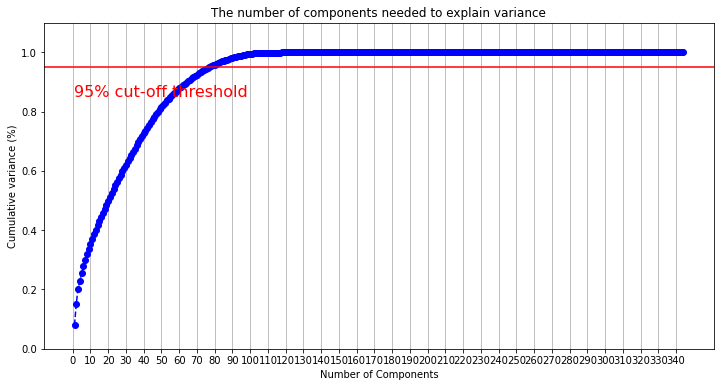

In [87]:
# Deciding n_components for PCA and SVD
data = pd.concat([train_df[features], predict_df[features]], axis=0)
pca = PCA().fit(data)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 345, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 344, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [88]:
# Generate PCA features
train, test = pca_fet(train_df, predict_df, features, n_components=80)

# Generate SVD features
train, test = svd_fet(train, test, features, n_components=80)

# Generate KMeans features
train, test = kmeans_fet(train, test, features, n_clusters=25)

In [89]:
combined_df = train.append(test, sort=False, ignore_index=True)
print(combined_df.shape)
combined_df.head()

(9743, 521)


,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,svd_50,svd_51,svd_52,svd_53,svd_54,svd_55,svd_56,svd_57,svd_58,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,clusters_k
0,37.0,2.0,0.0,0.0,1.0,68.0,0.0,1.095268,11.0,-0.093285,-0.336625,1.120205,-5.199338,-5.199338,1.168949,1.144237,-5.199338,-5.199338,-5.199338,1.366707,1.470545,0.544847,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,0.947401,-5.199338,-5.199338,-5.199338,0.544847,1.051717,-5.199338,-5.199338,0.889495,-5.199338,-5.199338,-5.199338,...,-0.790351,3.110549,-3.304939,-0.928733,3.995481,0.397731,1.662178,-0.354946,-1.238964,-4.377178,0.210524,-0.600681,0.009205,-4.199079,-0.783627,-2.469352,0.436639,0.360130,0.098508,-1.633233,-0.504075,-4.567876,-0.589511,1.444638,0.352419,4.766160,2.089413,0.001046,-1.365934,-0.439058,0.441253,-0.432068,-3.935155,1.491585,0.105960,-2.396995,-1.364972,-3.885616,7.254628,9
1,38.0,24.0,0.0,0.0,0.0,51.0,0.0,1.276367,12.0,1.623756,1.174605,1.120205,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,1.096804,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,0.269066,0.889495,-5.199338,-5.199338,-5.199338,...,-2.936085,5.467720,-1.393839,2.102502,-0.626619,9.720958,-3.575197,5.930209,-3.644820,-1.683363,-2.128193,0.132592,-0.423954,-0.926684,-0.407701,0.341400,-2.760700,1.092645,-4.020013,-0.237291,2.750775,1.170708,0.650540,-0.641045,-2.246807,0.718906,-0.774292,-1.337005,-0.124487,0.083809,0.167109,-2.339086,1.577826,2.121934,-4.448081,-1.172513,1.831098,-2.401822,4.348007,11
2,9.0,447.0,0.0,1.0,0.0,10.0,0.0,-0.037988,9.0,1.050085,0.494661,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,-5.199338,1.366707,1.470545,1.434200,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,-0.308666,1.639976,-5.199338,-5.199338,-5.199338,0.216904,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-4.437062,0.565634,-3.190919,6.463814,3.071990,-1.440150,-7.340923,-3.817865,2.489817,-0.596165,-2.861065,-0.754209,-1.659116,0.762286,3.474278,-1.804942,-1.144359,1.307197,3.134063,-1.801166,-0.227633,2.223932,0.041425,-3.187112,-3.855584,-2.559025,-1.078816,2.431805,-0.965180,-4.318529,8.261082,1.357820,-0.842303,-1.215149,1.297476,-1.583120,-0.490234,-0.368531,-0.529584,16
3,50.0,23.0,0.0,2.0,2.0,48.0,0.0,-0.895693,13.0,0.820525,2.357679,1.120205,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.096804,-5.199338,0.375793,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.203961,-5.199338,1.639976,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.269066,1.876359,-5.199338,-5.199338,-5.199338,...,5.939414,-0.492710,-0.321967,-5.179883,5.909321,0.131553,0.996865,8.357231,1.750821,-4.631697,-1.933093,0.693232,-4.129418,2.982879,3.639761,-1.485536,-4.860302,0.012015,-2.982515,1.056432,-2.483121,-0.442636,-0.708004,1.950670,1.560457,2.389356,0.026798,3.506622,5.254868,-1.431156,-2.235520,0.424299,-0.470932,-1.963088,-1.164332,-1.369209,0.162213,0.984326,0.030801,4
4,7.0,63.0,0.0,3.0,1.0,35.0,1.0,-0.416845,4.0,-0.363890,0.939705,-5.199338,1.194396,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.434200,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.308666,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.889495,1.639976,-5.199338,-5.199338,...,3.148330,-0.095360,10.525814,7.778518,2.022143,-5.064634,-6.918555,4.158041,-5.062166,1.388420,-1.289223,1.625429,1.052100,2.36

In [90]:
combined_df[combined_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,svd_50,svd_51,svd_52,svd_53,svd_54,svd_55,svd_56,svd_57,svd_58,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,clusters_k


### Feature Tools

In [91]:
combined_df['ID'] = combined_df.reset_index().index
combined_df.head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,svd_50,svd_51,svd_52,svd_53,svd_54,svd_55,svd_56,svd_57,svd_58,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,clusters_k,ID
0,37.0,2.0,0.0,0.0,1.0,68.0,0.0,1.095268,11.0,-0.093285,-0.336625,1.120205,-5.199338,-5.199338,1.168949,1.144237,-5.199338,-5.199338,-5.199338,1.366707,1.470545,0.544847,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,0.947401,-5.199338,-5.199338,-5.199338,0.544847,1.051717,-5.199338,-5.199338,0.889495,-5.199338,-5.199338,-5.199338,...,3.110549,-3.304939,-0.928733,3.995481,0.397731,1.662178,-0.354946,-1.238964,-4.377178,0.210524,-0.600681,0.009205,-4.199079,-0.783627,-2.469352,0.436639,0.360130,0.098508,-1.633233,-0.504075,-4.567876,-0.589511,1.444638,0.352419,4.766160,2.089413,0.001046,-1.365934,-0.439058,0.441253,-0.432068,-3.935155,1.491585,0.105960,-2.396995,-1.364972,-3.885616,7.254628,9,0
1,38.0,24.0,0.0,0.0,0.0,51.0,0.0,1.276367,12.0,1.623756,1.174605,1.120205,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,1.096804,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,0.269066,0.889495,-5.199338,-5.199338,-5.199338,...,5.467720,-1.393839,2.102502,-0.626619,9.720958,-3.575197,5.930209,-3.644820,-1.683363,-2.128193,0.132592,-0.423954,-0.926684,-0.407701,0.341400,-2.760700,1.092645,-4.020013,-0.237291,2.750775,1.170708,0.650540,-0.641045,-2.246807,0.718906,-0.774292,-1.337005,-0.124487,0.083809,0.167109,-2.339086,1.577826,2.121934,-4.448081,-1.172513,1.831098,-2.401822,4.348007,11,1
2,9.0,447.0,0.0,1.0,0.0,10.0,0.0,-0.037988,9.0,1.050085,0.494661,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,-5.199338,1.366707,1.470545,1.434200,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,-0.308666,1.639976,-5.199338,-5.199338,-5.199338,0.216904,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,0.565634,-3.190919,6.463814,3.071990,-1.440150,-7.340923,-3.817865,2.489817,-0.596165,-2.861065,-0.754209,-1.659116,0.762286,3.474278,-1.804942,-1.144359,1.307197,3.134063,-1.801166,-0.227633,2.223932,0.041425,-3.187112,-3.855584,-2.559025,-1.078816,2.431805,-0.965180,-4.318529,8.261082,1.357820,-0.842303,-1.215149,1.297476,-1.583120,-0.490234,-0.368531,-0.529584,16,2
3,50.0,23.0,0.0,2.0,2.0,48.0,0.0,-0.895693,13.0,0.820525,2.357679,1.120205,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.096804,-5.199338,0.375793,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.203961,-5.199338,1.639976,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.269066,1.876359,-5.199338,-5.199338,-5.199338,...,-0.492710,-0.321967,-5.179883,5.909321,0.131553,0.996865,8.357231,1.750821,-4.631697,-1.933093,0.693232,-4.129418,2.982879,3.639761,-1.485536,-4.860302,0.012015,-2.982515,1.056432,-2.483121,-0.442636,-0.708004,1.950670,1.560457,2.389356,0.026798,3.506622,5.254868,-1.431156,-2.235520,0.424299,-0.470932,-1.963088,-1.164332,-1.369209,0.162213,0.984326,0.030801,4,3
4,7.0,63.0,0.0,3.0,1.0,35.0,1.0,-0.416845,4.0,-0.363890,0.939705,-5.199338,1.194396,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.434200,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.308666,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.889495,1.639976,-5.199338,-5.199338,...,-0.095360,10.525814,7.778518,2.022143,-5.064634,-6.918555,4.158041,-5.062166,1.388420,-1.289223,1.625429,1.052100,2.366218,-1.811195,-3.566841,-3.241902,1.418685,

In [92]:
feature_df = pd.DataFrame()
feature_df = combined_df[['ID','Stall_no','Market_Category','Loyalty_customer',
                          'Product_Category','Grade','Demand','Discount_avail',
                          'instock_time','charges_1','charges_2 (%)','Minimum_price',
                          'Maximum_price','clusters_k','instock_date_year',
                          'instock_date_quarter','instock_date_month',
                          'instock_date_day_week','instock_date_day_weekend']]
feature_df.head()

,ID,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,instock_time,charges_1,charges_2 (%),Minimum_price,Maximum_price,clusters_k,instock_date_year,instock_date_quarter,instock_date_month,instock_date_day_week,instock_date_day_weekend
0,0,37.0,2.0,0.0,0.0,1.0,68.0,0.0,4.0,1.095268,11.0,-0.093285,-0.336625,9,2015.0,3.0,8.0,5.0,1.0
1,1,38.0,24.0,0.0,0.0,0.0,51.0,0.0,4.0,1.276367,12.0,1.623756,1.174605,11,2016.0,1.0,3.0,6.0,1.0
2,2,9.0,447.0,0.0,1.0,0.0,10.0,0.0,4.0,-0.037988,9.0,1.050085,0.494661,16,2015.0,3.0,8.0,1.0,0.0
3,3,50.0,23.0,0.0,2.0,2.0,48.0,0.0,4.0,-0.895693,13.0,0.820525,2.357679,4,2016.0,1.0,3.0,0.0,0.0
4,4,7.0,63.0,0.0,3.0,1.0,35.0,1.0,4.0,-0.416845,4.0,-0.363890,0.939705,11,2016.0,1.0,3.0,1.0,0.0


In [93]:
es = ft.EntitySet(id='Carnival')
es.entity_from_dataframe(entity_id='CW', dataframe=feature_df, index='ID')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Stall_no', index='Stall_no')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Market_Category', index='Market_Category')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Loyalty_customer', index='Loyalty_customer')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Product_Category', index='Product_Category')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Grade', index='Grade')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Demand', index='Demand')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='Discount_avail', index='Discount_avail')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='charges_2 (%)', index='charges_2 (%)')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_date_year', index='instock_date_year')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_date_quarter', index='instock_date_quarter')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_date_month', index='instock_date_month')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_date_day_week', index='instock_date_day_week')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_date_day_weekend', index='instock_date_day_weekend')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='instock_time', index='instock_time')
es = es.normalize_entity(base_entity_id='CW', new_entity_id='clusters_k', index='clusters_k')
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='CW', 
                                       agg_primitives=['mean','sum','count','max','min'],
                                       max_depth=2, verbose=3, n_jobs=1)
print(feature_matrix.shape)
feature_matrix.head()

Built 213 features
Elapsed: 00:00 | Progress: 100%|██████████
(9743, 213)


,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,instock_time,charges_1,charges_2 (%),Minimum_price,Maximum_price,clusters_k,instock_date_year,instock_date_quarter,instock_date_month,instock_date_day_week,instock_date_day_weekend,Stall_no.COUNT(CW),Stall_no.MAX(CW.Maximum_price),Stall_no.MAX(CW.Minimum_price),Stall_no.MAX(CW.charges_1),Stall_no.MEAN(CW.Maximum_price),Stall_no.MEAN(CW.Minimum_price),Stall_no.MEAN(CW.charges_1),Stall_no.MIN(CW.Maximum_price),Stall_no.MIN(CW.Minimum_price),Stall_no.MIN(CW.charges_1),Stall_no.SUM(CW.Maximum_price),Stall_no.SUM(CW.Minimum_price),Stall_no.SUM(CW.charges_1),Market_Category.COUNT(CW),Market_Category.MAX(CW.Maximum_price),Market_Category.MAX(CW.Minimum_price),Market_Category.MAX(CW.charges_1),Market_Category.MEAN(CW.Maximum_price),Market_Category.MEAN(CW.Minimum_price),Market_Category.MEAN(CW.charges_1),Market_Category.MIN(CW.Maximum_price),Market_Category.MIN(CW.Minimum_price),...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,37.0,2.0,0.0,0.0,1.0,68.0,0.0,4.0,1.095268,11.0,-0.093285,-0.336625,9,2015.0,3.0,8.0,5.0,1.0,204,2.352618,2.697656,2.482149,-0.025622,-0.032486,-0.030797,-2.662958,-2.342933,-5.199338,-5.226944,-6.627235,-6.282526,40,1.670661,1.540837,5.199338,0.608866,0.643102,-0.091378,-0.727387,-0.438699,...,0.348227,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,242,0.732854,0.509452,2.807574,-0.804138,-0.968632,-0.198779,-2.051377,-2.340210,-2.283271,-194.601473,-234.408908,-48.104517
1,38.0,24.0,0.0,0.0,0.0,51.0,0.0,4.0,1.276367,12.0,1.623756,1.174605,11,2016.0,1.0,3.0,6.0,1.0,187,2.363735,2.160060,3.091419,0.026595,0.008493,0.024129,-2.455632,-2.059373,-2.525822,4.973307,1.588150,4.512099,322,1.408078,1.901444,2.748077,0.364643,0.796200,-0.016269,-1.173859,-0.545393,...,-9.978231,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,296,2.363616,2.343044,3.091419,0.233764,0.170855,0.018130,-1.643605,-2.360931,-5.199338,69.194102,50.572952,5.366550
2,9.0,447.0,0.0,1.0,0.0,10.0,0.0,4.0,-0.037988,9.0,1.050085,0.494661,16,2015.0,3.0,8.0,1.0,0.0,213,2.326082,2.434784,2.611566,-0.019929,0.021

In [94]:
feature_matrix[feature_matrix.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,instock_time,charges_1,charges_2 (%),Minimum_price,Maximum_price,clusters_k,instock_date_year,instock_date_quarter,instock_date_month,instock_date_day_week,instock_date_day_weekend,Stall_no.COUNT(CW),Stall_no.MAX(CW.Maximum_price),Stall_no.MAX(CW.Minimum_price),Stall_no.MAX(CW.charges_1),Stall_no.MEAN(CW.Maximum_price),Stall_no.MEAN(CW.Minimum_price),Stall_no.MEAN(CW.charges_1),Stall_no.MIN(CW.Maximum_price),Stall_no.MIN(CW.Minimum_price),Stall_no.MIN(CW.charges_1),Stall_no.SUM(CW.Maximum_price),Stall_no.SUM(CW.Minimum_price),Stall_no.SUM(CW.charges_1),Market_Category.COUNT(CW),Market_Category.MAX(CW.Maximum_price),Market_Category.MAX(CW.Minimum_price),Market_Category.MAX(CW.charges_1),Market_Category.MEAN(CW.Maximum_price),Market_Category.MEAN(CW.Minimum_price),Market_Category.MEAN(CW.charges_1),Market_Category.MIN(CW.Maximum_price),Market_Category.MIN(CW.Minimum_price),...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [95]:
feature_matrix.drop(['Stall_no','Market_Category','Loyalty_customer',
                     'Product_Category','Grade','Demand','Discount_avail',
                     'instock_time','charges_1','charges_2 (%)','Minimum_price',
                     'Maximum_price','clusters_k','instock_date_year',
                     'instock_date_quarter','instock_date_month',
                     'instock_date_day_week','instock_date_day_weekend'], axis=1, inplace=True)
feature_df = feature_matrix.copy()

In [96]:
combined_df.set_index('ID', inplace = True)
temp_df = pd.merge(combined_df, feature_df, how='inner', on='ID', sort=False, suffixes=('_x', '_y'))
print(temp_df.shape)
temp_df.head()

(9743, 716)


,Stall_no,Market_Category,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,37.0,2.0,0.0,0.0,1.0,68.0,0.0,1.095268,11.0,-0.093285,-0.336625,1.120205,-5.199338,-5.199338,1.168949,1.144237,-5.199338,-5.199338,-5.199338,1.366707,1.470545,0.544847,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,0.947401,-5.199338,-5.199338,-5.199338,0.544847,1.051717,-5.199338,-5.199338,0.889495,-5.199338,-5.199338,-5.199338,...,0.348227,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,242,0.732854,0.509452,2.807574,-0.804138,-0.968632,-0.198779,-2.051377,-2.340210,-2.283271,-194.601473,-234.408908,-48.104517
1,38.0,24.0,0.0,0.0,0.0,51.0,0.0,1.276367,12.0,1.623756,1.174605,1.120205,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,1.096804,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,0.269066,0.889495,-5.199338,-5.199338,-5.199338,...,-9.978231,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,296,2.363616,2.343044,3.091419,0.233764,0.170855,0.018130,-1.643605,-2.360931,-5.199338,69.194102,50.572952,5.366550
2,9.0,447.0,0.0,1.0,0.0,10.0,0.0,-0.037988,9.0,1.050085,0.494661,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,-5.199338,1.366707,1.470545,1.434200,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,-0.308666,1.639976,-5.199338,-5.199338,-5.199338,0.216904,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,9.347824,7289,5.199338,5.199338,5.199338,-0.034437,-0.040998,-0.012369,-5.199338,-5.199338,-5.199338,-251.014398,-298.831175,-90.156053,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,488,1.922008,2.059606,2.696886,0.744744,0.747367,0.071446,-0.532696,-

In [97]:
combined_df = temp_df.copy()

### Define categorical columns

In [98]:
categorical_columns = ['Stall_no','Market_Category','Loyalty_customer',
                       'Product_Category','instock_time','Grade_Bin','Grade',
                       'Demand','Discount_avail','instock_date_year','charges_2 (%)',
                       'instock_date_quarter','Market_Bin','instock_date_month',
                       'instock_date_day_week','instock_date_day_weekend',
                       'clusters_k']
categorical_columns_indices = [combined_df.columns.get_loc(col) for col in categorical_columns]
print(categorical_columns_indices)

[0, 1, 2, 3, 122, 224, 4, 5, 6, 111, 8, 112, 123, 113, 117, 118, 520]


In [99]:
combined_df[categorical_columns] = combined_df[categorical_columns].astype(int)
combined_df[categorical_columns].head()

,Stall_no,Market_Category,Loyalty_customer,Product_Category,instock_time,Grade_Bin,Grade,Demand,Discount_avail,instock_date_year,charges_2 (%),instock_date_quarter,Market_Bin,instock_date_month,instock_date_day_week,instock_date_day_weekend,clusters_k
ID,,,,,,,,,,,,,,,,,
0,37,2,0,0,4,1,1,68,0,2015,11,3,1,8,5,1,9
1,38,24,0,0,4,1,0,51,0,2016,12,1,1,3,6,1,11
2,9,447,0,1,4,1,0,10,0,2015,9,3,3,8,1,0,16
3,50,23,0,2,4,2,2,48,0,2016,13,1,1,3,0,0,4
4,7,63,0,3,4,1,1,35,1,2016,4,1,1,3,1,0,11


### Scale the continuous column values

In [100]:
# Segregate combined_df into train/predict datasets
train_df = combined_df[:6313].copy().reset_index()
predict_df = combined_df[6313:].copy().reset_index()

# Drop and recreate dataframe indexes
train_df.drop(['ID'], axis=1, inplace=True)
predict_df.drop(['ID'], axis=1, inplace=True)
train_df['ID'] = train_df.reset_index().index
predict_df['ID'] = predict_df.reset_index().index
train_df.set_index('ID', inplace = True)
predict_df.set_index('ID', inplace = True)

print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (6313, 716)
predict_df: (3430, 716)


In [101]:
cont_cols = [i for i in train_df.columns if i not in categorical_columns]

In [102]:
temp_df1 = train_df[cont_cols]
print("temp_df1: {}".format(temp_df1.shape))
temp_df1.head()

temp_df1: (6313, 699)


,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,cvp_m,cvp_n,cvp_nk,cvp_nkc,cvp_nkce,cvp_p,cvp_q,cvp_r,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.095268,-0.093285,-0.336625,1.120205,-5.199338,-5.199338,1.168949,1.144237,-5.199338,-5.199338,-5.199338,1.366707,1.470545,0.544847,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,0.947401,-5.199338,-5.199338,-5.199338,0.544847,1.051717,-5.199338,-5.199338,0.889495,-5.199338,-5.199338,-5.199338,-5.199338,0.530220,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.544847,...,0.348227,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,242,0.732854,0.509452,2.807574,-0.804138,-0.968632,-0.198779,-2.051377,-2.340210,-2.283271,-194.601473,-234.408908,-48.104517
1,1.276367,1.623756,1.174605,1.120205,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,1.096804,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,0.544847,-5.199338,-5.199338,0.269066,0.889495,-5.199338,-5.199338,-5.199338,-5.199338,1.549706,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.544847,...,-9.978231,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.06482,296,2.363616,2.343044,3.091419,0.233764,0.170855,0.018130,-1.643605,-2.360931,-5.199338,69.194102,50.572952,5.366550
2,-0.037988,1.050085,0.494661,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.144237,-5.199338,-5.199338,1.366707,1.470545,1.434200,1.549706,5.199338,5.199338,-5.199338,-5.199338,-5.199338,-0.308666,1.639976,-5.199338,-5.199338,-5.199338,0.216904,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.639976,0.870846,1.508944,...,9.347824,7289,5.199338,5.199338,5.199338,-0.034437,-0.040998,-0.012369,-5.199338,-5.199338,-5.199338,-251.014398,-298.831175,-90.156053,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694

In [103]:
temp_df2 = predict_df[cont_cols]
print("temp_df2: {}".format(temp_df2.shape))
temp_df2.head()

temp_df2: (3430, 699)


,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,cvp_m,cvp_n,cvp_nk,cvp_nkc,cvp_nkce,cvp_p,cvp_q,cvp_r,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.129790,-0.293973,-0.957082,-5.199338,-5.199338,1.220640,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.203961,-5.199338,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.269066,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.682458,-5.199338,-5.199338,...,54.864450,7289,5.199338,5.199338,5.199338,-0.034437,-0.040998,-0.012369,-5.199338,-5.199338,-5.199338,-251.014398,-298.831175,-90.156053,957,5.199338,2.638085,3.091419,0.015575,0.049910,0.002048,-5.199338,-2.425035,-5.199338,14.905520,47.763925,1.959878,326,0.642385,0.274422,2.611566,-1.087306,-1.090068,0.020166,-3.095335,-2.383309,-2.525822,-354.461614,-355.362109,6.574083
1,1.240635,-1.172286,-1.688037,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.366707,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.876359,1.247754,-5.199338,-0.308666,-5.199338,-5.199338,1.508944,-5.199338,0.216904,-5.199338,1.144237,-5.199338,0.635270,-5.199338,-5.199338,-5.199338,0.530220,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.544847,...,-9.978231,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,190.972694,-53.064820,326,0.642385,0.274422,2.611566,-1.087306,-1.090068,0.020166,-3.095335,-2.383309,-2.525822,-354.461614,-355.362109,6.574083
2,1.424762,1.504724,1.967491,-5.199338,-5.199338,-5.199338,1.168949,1.144237,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.203961,1.247754,0.666564,-0.308666,-5.199338,-5.199338,-5.199338,-5.199338,0.216904,-5.199338,-5.199338,1.876359,0.635270,1.366707,5.199338,-5.199338,2.322575,1.366707,1.399657,5.199338,-5.199338,-5.199338,-5.199338,...,0.348227,2454,2.388224,2.872667,3.291867,0.011427,0.065257,-0.003924,-2.909431,-2.411001,-5.199338,28.042404,160.141856,-9.630005,3276,2.465325,5.199338,3.291867,0.166658,0.058294,-0.016198,-5.199338,-2.485626,-5.199338,545.972611,

In [104]:
scaler = RobustScaler().fit(temp_df1)
temp_x1 = scaler.transform(temp_df1)
temp_x2 = scaler.transform(temp_df2)

In [105]:
temp_df1 = pd.DataFrame(temp_x1, columns=cont_cols)
temp_df2 = pd.DataFrame(temp_x2, columns=cont_cols)

In [106]:
temp_df1['ID'] = temp_df1.reset_index().index
temp_df1.set_index('ID', inplace = True)
temp_df1.head()

,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,cvp_m,cvp_n,cvp_nk,cvp_nkc,cvp_nkce,cvp_p,cvp_q,cvp_r,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.811077,-0.069989,-0.249952,6.319543,0.000000,0.0,6.368286,6.343575,0.000000,0.000000,0.0,0.177738,6.669883,1.000000,6.749043,10.398675,10.398675,-1.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,1.0,0.154131,0.0,-1.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,...,0.000000,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,-1.098039,-1.738419,-1.769447,0.150803,-1.188302,-1.766438,-2.566897,-0.759584,-0.251956,2.916067,-0.815917,-0.982673,-1.504053
1,0.945188,1.207158,0.872067,6.319543,0.000000,0.0,0.000000,6.343575,0.000000,6.296141,0.0,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,1.0,-1.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.177935,0.0,0.0,0.0,0.000000,0.0,1.000000,...,-0.244100,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,-0.745098,0.505394,0.563446,0.870249,0.229374,0.253320,0.513477,-0.206778,-0.283373,0.000000,0.158572,0.157772,0.575339
2,-0.028151,0.780457,0.367240,0.000000,0.000000,0.0,0.000000,0.000000,6.343575,0.000000,0.0,0.177738,6.669883,1.154827,6.749043,10.398675,10.398675,-1.0,0.0,0.000000,0.000000,6.839314,0.0,0.0,0.0,0.000000,0.0,-1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.162794,1.0,1.167839,...,0.212735,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,0.509804,-0.102227,0.202825,-0.129751,0.927325,1.275197,1.270623,1.299252,1.522253,0.000000,1.245531,1.414912,1.722500
3,-0.663319,0.609709,1.750446,6.319543,0.000000,0.0,0.000000,0.000000,0.000000,6.296141,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.165944,-3.893639,0.000000,0.0,0.0,0.0,-1.000000,0.0,0.0,1.162078,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,1.0,0.000000,...,-0.445151,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00

In [107]:
temp_df2['ID'] = temp_df2.reset_index().index
temp_df2.set_index('ID', inplace = True)
temp_df2.head()

,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,cvp_eg,cvp_f,cvp_g,cvp_ge,cvp_h,cvp_j,cvp_k,cvp_kc,cvp_kce,cvp_m,cvp_n,cvp_nk,cvp_nkc,cvp_nkce,cvp_p,cvp_q,cvp_r,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.836641,-0.219262,-0.710612,0.0,0.000000,6.419978,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,-1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,1.288671,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.351399,25.016432,-0.023273,-0.105086,-0.316954,-0.032262,0.946964,0.0,0.022306,0.0,-0.192866,-0.155776,0.857669,-0.549020,-1.862897,-2.068477,-0.346008,-1.575081,-1.981685,0.542386,-2.174851,-0.317304,2.673516,-1.406458,-1.466705,0.622297
1,0.918727,-0.872557,-1.253313,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.177738,0.0,0.000000,0.0,0.0,0.0,0.309514,6.447091,0.000000,0.0,0.0,0.0,6.708281,0.000000,0.0,0.0,0.160041,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,-0.244100,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.000000,0.936335,0.977369,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.125892,0.000000,0.000000,-0.549020,-1.862897,-2.068477,-0.346008,-1.575081,-1.981685,0.542386,-2.174851,-0.317304,2.673516,-1.406458,-1.466705,0.622297
2,1.055082,1.118621,1.460749,0.0,0.000000,0.000000,6.368286,6.343575,0.0,0.000000,0.000000,-1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,6.447091,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-1.000000,1.162078,1.000000,6.566045,10.398675,0.0,1.312826,6.566045,6.598994,10.398675,0.000000,0.0,0.0,...,0.000000,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.000000,0.936335,0.977369,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.125892,0.000000,0.000000,-0.503268,0.496694,0.798954,0.559274,1.334320,2.044122,-0.179597,2.158135,2.221981,2.673516,1.185641,1.529424,-0.030573
3,0.455280,0.694303,1.157603,0.0,6.393733,0.000000,0.000000,0.000000,0.0,6.296141,0.000000,-1.000000,0.0,1.154827,0.0,0.0,0.0,0.000000,6.447091,1.165944,0.0,0.0,0.0,0.000000,0.000000,-1.0,0.0,0.16004

In [108]:
train_df = pd.merge(train_df[categorical_columns], temp_df1, how='inner', on='ID', sort=False, suffixes=('_x', '_y'))
print(train_df.shape)
train_df.head()

(6313, 716)


,Stall_no,Market_Category,Loyalty_customer,Product_Category,instock_time,Grade_Bin,Grade,Demand,Discount_avail,instock_date_year,charges_2 (%),instock_date_quarter,Market_Bin,instock_date_month,instock_date_day_week,instock_date_day_weekend,clusters_k,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,37,2,0,0,4,1,1,68,0,2015,11,3,1,8,5,1,9,0.811077,-0.069989,-0.249952,6.319543,0.000000,0.0,6.368286,6.343575,0.000000,0.000000,0.0,0.177738,6.669883,1.000000,6.749043,10.398675,10.398675,-1.0,0.0,0.000000,1.000000,0.000000,0.0,...,0.000000,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,-1.098039,-1.738419,-1.769447,0.150803,-1.188302,-1.766438,-2.566897,-0.759584,-0.251956,2.916067,-0.815917,-0.982673,-1.504053
1,38,24,0,0,4,1,0,51,0,2016,12,1,1,3,6,1,11,0.945188,1.207158,0.872067,6.319543,0.000000,0.0,0.000000,6.343575,0.000000,6.296141,0.0,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.0,0.0,1.000000,0.000000,0.000000,0.0,...,-0.244100,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,-0.745098,0.505394,0.563446,0.870249,0.229374,0.253320,0.513477,-0.206778,-0.283373,0.000000,0.158572,0.157772,0.575339
2,9,447,0,1,4,1,0,10,0,2015,9,3,3,8,1,0,16,-0.028151,0.780457,0.367240,0.000000,0.000000,0.0,0.000000,0.000000,6.343575,0.000000,0.0,0.177738,6.669883,1.154827,6.749043,10.398675,10.398675,-1.0,0.0,0.000000,0.000000,6.839314,0.0,...,0.212735,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125892,0.0,0.0,0.509804,-0.102227,0.202825,-0.129751,0.927325,1.275197,1.270623,1.299252,1.522253,0.000000,1.245531,1.414912,1.722500
3,50,23,0,2,4,2,2,48,0,2016,13,1,1,3,0,0,4,-0.663319,0.609709,1.750446,6.319543,0.000000,0.0,0.000000,0.000000,0.000000,6.296141,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.165944,-3.893639,0.000000,0.0,...,-0.445151,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.936335,0.977369,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [109]:
predict_df = pd.merge(predict_df[categorical_columns], temp_df2, how='inner', on='ID', sort=False, suffixes=('_x', '_y'))
print(predict_df.shape)
predict_df.head()

(3430, 716)


,Stall_no,Market_Category,Loyalty_customer,Product_Category,instock_time,Grade_Bin,Grade,Demand,Discount_avail,instock_date_year,charges_2 (%),instock_date_quarter,Market_Bin,instock_date_month,instock_date_day_week,instock_date_day_weekend,clusters_k,charges_1,Minimum_price,Maximum_price,cvp_2,cvp_3,cvp_4,cvp_5,cvp_6,cvp_7,cvp_8,cvp_9,cvp_a,cvp_ae,cvp_b,cvp_br,cvp_bra,cvp_brae,cvp_c,cvp_ce,cvp_d,cvp_e,cvp_ea,cvp_ec,...,instock_date_day_week.SUM(CW.charges_1),instock_date_day_weekend.COUNT(CW),instock_date_day_weekend.MAX(CW.Maximum_price),instock_date_day_weekend.MAX(CW.Minimum_price),instock_date_day_weekend.MAX(CW.charges_1),instock_date_day_weekend.MEAN(CW.Maximum_price),instock_date_day_weekend.MEAN(CW.Minimum_price),instock_date_day_weekend.MEAN(CW.charges_1),instock_date_day_weekend.MIN(CW.Maximum_price),instock_date_day_weekend.MIN(CW.Minimum_price),instock_date_day_weekend.MIN(CW.charges_1),instock_date_day_weekend.SUM(CW.Maximum_price),instock_date_day_weekend.SUM(CW.Minimum_price),instock_date_day_weekend.SUM(CW.charges_1),instock_time.COUNT(CW),instock_time.MAX(CW.Maximum_price),instock_time.MAX(CW.Minimum_price),instock_time.MAX(CW.charges_1),instock_time.MEAN(CW.Maximum_price),instock_time.MEAN(CW.Minimum_price),instock_time.MEAN(CW.charges_1),instock_time.MIN(CW.Maximum_price),instock_time.MIN(CW.Minimum_price),instock_time.MIN(CW.charges_1),instock_time.SUM(CW.Maximum_price),instock_time.SUM(CW.Minimum_price),instock_time.SUM(CW.charges_1),clusters_k.COUNT(CW),clusters_k.MAX(CW.Maximum_price),clusters_k.MAX(CW.Minimum_price),clusters_k.MAX(CW.charges_1),clusters_k.MEAN(CW.Maximum_price),clusters_k.MEAN(CW.Minimum_price),clusters_k.MEAN(CW.charges_1),clusters_k.MIN(CW.Maximum_price),clusters_k.MIN(CW.Minimum_price),clusters_k.MIN(CW.charges_1),clusters_k.SUM(CW.Maximum_price),clusters_k.SUM(CW.Minimum_price),clusters_k.SUM(CW.charges_1)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,39,205,1,0,2,1,0,90,0,2016,16,1,3,1,2,0,3,0.836641,-0.219262,-0.710612,0.0,0.000000,6.419978,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,...,1.288671,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.351399,25.016432,-0.023273,-0.105086,-0.316954,-0.032262,0.946964,0.0,0.022306,0.0,-0.192866,-0.155776,0.857669,-0.549020,-1.862897,-2.068477,-0.346008,-1.575081,-1.981685,0.542386,-2.174851,-0.317304,2.673516,-1.406458,-1.466705,0.622297
1,49,3,0,0,4,1,0,87,0,2015,16,3,1,8,6,1,3,0.918727,-0.872557,-1.253313,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.177738,0.0,0.000000,0.0,0.0,0.0,0.309514,6.447091,0.000000,0.0,0.0,0.0,...,-0.244100,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.000000,0.936335,0.977369,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.125892,0.000000,0.000000,-0.549020,-1.862897,-2.068477,-0.346008,-1.575081,-1.981685,0.542386,-2.174851,-0.317304,2.673516,-1.406458,-1.466705,0.622297
2,1,183,1,4,4,2,2,55,0,2015,9,4,2,11,5,1,23,1.055082,1.118621,1.460749,0.0,0.000000,0.000000,6.368286,6.343575,0.0,0.000000,0.000000,-1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,6.447091,1.000000,0.0,0.0,0.0,...,0.000000,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973031,80.526048,0.000000,0.936335,0.977369,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.125892,0.000000,0.000000,-0.503268,0.496694,0.798954,0.559274,1.334320,2.044122,-0.179597,2.158135,2.221981,2.673516,1.185641,1.529424,-0.030573
3,8,358,0,1,1,2,3,86,0,2015,16,4,3,11,5,1,23,0.455280,0.694303,1.157603,0.0,6.393733,0.000000,0.000000,0.000000,0.0,6.296141,0.000000,-1.000000,0.0,1.154827,0.0,0.0,0.0,0.000000,6.447091,1.165944,0.0,0.0,0.0,...,0.000000,-4835.0,-2.811114,-2.326671,-1.90747,0.045865,0.106255,0.008445,2.289907,2.788337,0.0,279.056801,458.973

## Save the processed datasets

In [110]:
data_dict = {}
data_dict['Xtrain'] = train_df
data_dict['Xpredict'] = predict_df
data_dict['Ytrain'] = train_y

In [111]:
file = open("/content/drive/My Drive/Colab Notebooks/Carnival Wars/Carnival_Wars_Dataset.txt", 'wb')
pickle.dump(data_dict, file)
file.close()